In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, Input
from PIL import Image, UnidentifiedImageError
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, Activation, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom


In [2]:
train_dir = '/Users/sneharaut/Desktop/Flower_Classification/Train'
test_dir = '/Users/sneharaut/Desktop/Flower_Classification/Test'

In [3]:
import os

print(os.listdir(".."))


['sample_images.png', '.DS_Store', 'Test', 'AI-ML-Assesment', 'Dataset Description-2.txt', 'training_history.png', 'augmented_images.png', 'backup_files', 'flower_classification.ipynb', 'Train', '.ipynb_checkpoints', 'baseline_flower_cnn.h5']


# Part A: Implementing Convolutional Neural Network from scratch

## Data Understanding, Analysis, Visualization and Cleaning

In [4]:
# List to store corrupted image paths
corrupted_images = []

# Iterate through each class subdirectory
for class_name in os.listdir(train_dir):
    if class_name.startswith('.'):  # Skip hidden folders like .ipynb_checkpoints
        continue

    class_path = os.path.join(train_dir, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image_file in os.listdir(class_path):
            if image_file.startswith('.'):  # Skip hidden files
                continue

            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify if the image can be opened
            except (IOError, SyntaxError, PermissionError):
                corrupted_images.append(image_path)
                try:
                    os.remove(image_path)
                    print(f"Removed corrupted image: {image_path}")
                except Exception as e:
                    print(f"Could not delete {image_path}: {e}")

# Print summary
if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [5]:
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

total_images = sum(class_counts.values())

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)
print(f"{'Total Images':<25}{total_images:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
daisy                                756
rose                                 776
tulip                                976
dandelion                           1044
sunflower                            725
Total Images                        4277


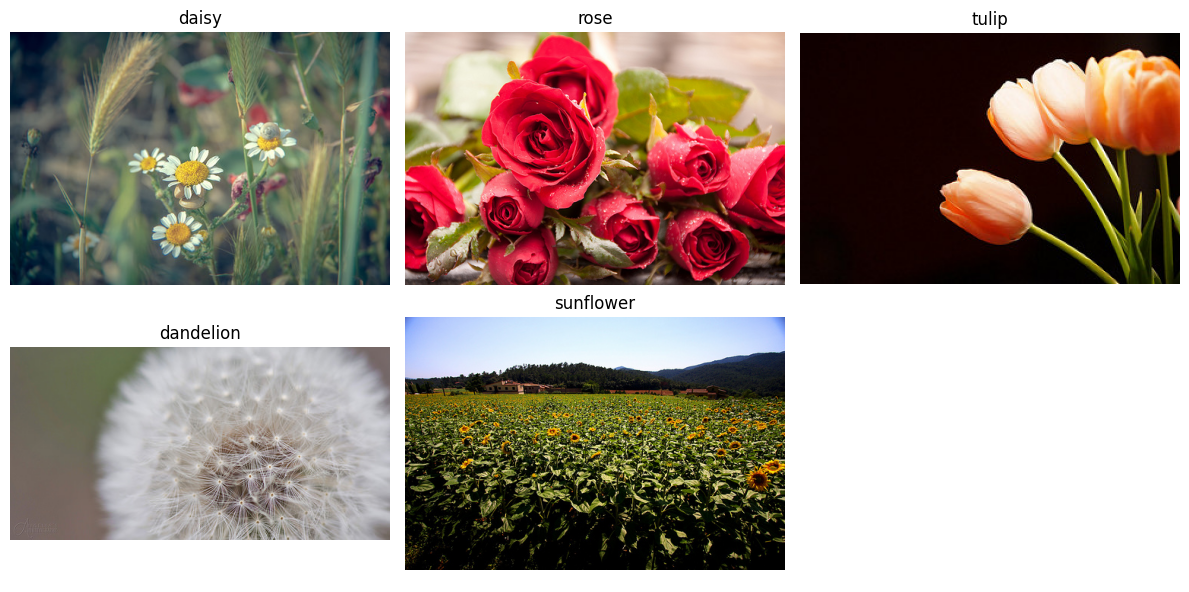

In [6]:
selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png','.jpg','.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
cols = (num_classes + 1) // 2
rows = 2
fig, axes = plt.subplots(rows,cols,figsize = (12,6))
for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")
plt.tight_layout()
plt.show()

Using image: /Users/sneharaut/Desktop/Flower_Classification/Train/daisy/14167534527_781ceb1b7a_n.jpg


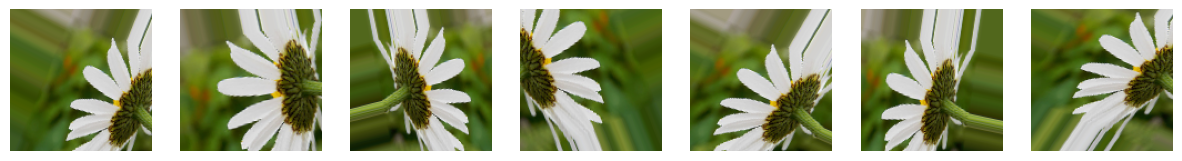

In [47]:
# Pick the first image from the first class folder
first_class_path = os.path.join(train_dir, class_names[0])
image_files = [f for f in os.listdir(first_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    raise ValueError(f"No image files found in {first_class_path}")
    
sample_img_path = os.path.join(first_class_path, image_files[0])
print(f"Using image: {sample_img_path}")

# Load and preprocess image
img = image.load_img(sample_img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
aug_iter = datagen.flow(x, batch_size=1)

# Display augmented images
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
    batch = next(aug_iter)
    ax[i].imshow(batch[0].astype('uint8'))
    ax[i].axis('off')

plt.show()

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 3424 images belonging to 5 classes.
Found 855 images belonging to 5 classes.


## Design, Train, and Evaluate a Baseline Model

In [35]:
model.save('cnn_model.keras')


In [9]:
model = Sequential([
    # Layer 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2,2)),

    # Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Layer 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    # Output Layer
    Dense(5, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print summary
model.summary()


/Users/sneharaut/tensorflow_eni/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-12 17:14:14.408379: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-12 17:14:14.408611: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-12 17:14:14.408621: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-12 17:14:14.408861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-12 17:14:14.408898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_facto

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,557,509 (25.01 MB)

 Trainable params: 6,557,509 (25.01 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

/Users/sneharaut/tensorflow_eni/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


2025-05-12 17:14:18.792297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.2500 - loss: 2.3535 - val_accuracy: 0.3637 - val_loss: 1.3775
Epoch 2/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.4131 - loss: 1.4398 - val_accuracy: 0.4749 - val_loss: 1.3121
Epoch 3/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.4405 - loss: 1.4603 - val_accuracy: 0.3836 - val_loss: 1.3536
Epoch 4/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 0.4428 - loss: 1.3063 - val_accuracy: 0.4421 - val_loss: 1.3251
Epoch 5/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - accuracy: 0.4701 - loss: 1.3557 - val_accuracy: 0.5099 - val_loss: 1.2035
Epoch 6/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.3968 - loss: 1.9264 - val_accuracy: 0.3450 - val_loss: 1.7286
Epoch 7/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.4157 - loss: 1.6665 - val_accuracy: 0.4491 - val_loss: 2.2174
Epoch 8/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.3035 - loss: 4.3268 - val

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from tensorflow.keras.callbacks import EarlyStopping


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
NUM_CLASSES = 5  # Set your number of classes here
input_shape = (128, 128, 3)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/Users/sneharaut/Desktop/Flower_Classification/Train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    '/Users/sneharaut/Desktop/Flower_Classification/Train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# CNN Model
model = Sequential()

# Conv Block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 3
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 4
model.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 5
model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model architecture
model.summary()

# Train the model
start_time = time.time()

early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=5,             
    restore_best_weights=True,  
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stop],  
    verbose=1
)



end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()
print("Saved training history as 'training_history.png'")


Found 3424 images belonging to 5 classes.
Found 855 images belonging to 5 classes.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,671,013 (14.00 MB)

 Trainable params: 3,668,517 (13.99 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.4299 - loss: 1.6101 - val_accuracy: 0.2444 - val_loss: 3.3787
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6547 - loss: 0.9247 - val_accuracy: 0.2444 - val_loss: 3.6889
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.7558 - loss: 0.6687 - val_accuracy: 0.2585 - val_loss: 3.2266
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.8148 - loss: 0.5357 - val_accuracy: 0.4105 - val_loss: 2.0321
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.8690 - loss: 0.3817 - val_accuracy: 0.6000 - val_loss: 1.0408
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9019 - loss: 0.2893 - val_accuracy: 0.6830 - val_loss: 0.8793
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9254 - loss: 0.2369 - val_accuracy: 0.6561 - val_loss: 1.0046
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.9606 - loss: 0

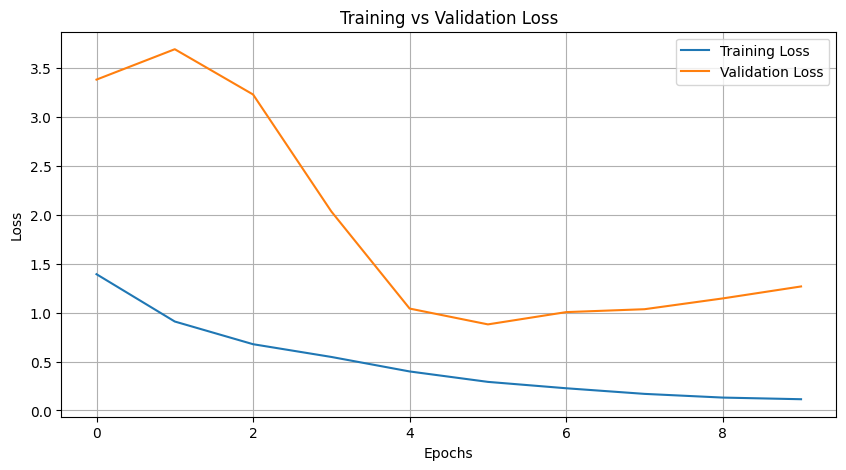

In [50]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

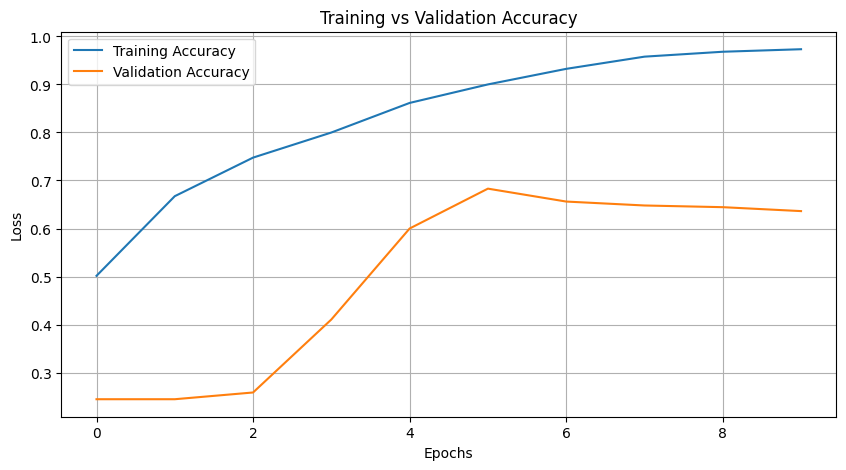

In [51]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

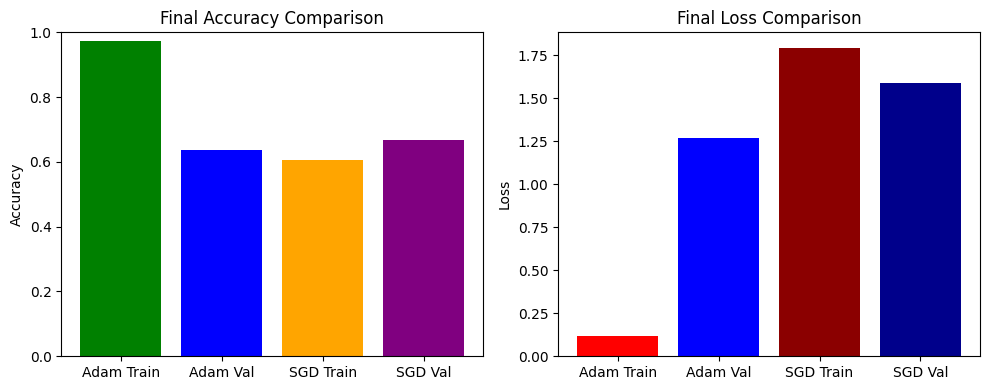

In [67]:
import matplotlib.pyplot as plt

# Final metrics from both models
adam_train_acc = history.history['accuracy'][-1]
adam_val_acc = history.history['val_accuracy'][-1]
adam_train_loss = history.history['loss'][-1]
adam_val_loss = history.history['val_loss'][-1]

sgd_train_acc = DeepModel_history_SGD.history['accuracy'][-1]
sgd_val_acc = DeepModel_history_SGD.history['val_accuracy'][-1]
sgd_train_loss = DeepModel_history_SGD.history['loss'][-1]
sgd_val_loss = DeepModel_history_SGD.history['val_loss'][-1]

# Accuracy bar chart
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(['Adam Train', 'Adam Val', 'SGD Train', 'SGD Val'],
        [adam_train_acc, adam_val_acc, sgd_train_acc, sgd_val_acc],
        color=['green', 'blue', 'orange', 'purple'])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Loss bar chart
plt.subplot(1, 2, 2)
plt.bar(['Adam Train', 'Adam Val', 'SGD Train', 'SGD Val'],
        [adam_train_loss, adam_val_loss, sgd_train_loss, sgd_val_loss],
        color=['red', 'blue', 'darkred', 'darkblue'])
plt.title('Final Loss Comparison')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()  # This will display the charts on the shell


In [53]:

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

Found 855 images belonging to 5 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
              precision    recall  f1-score   support

       daisy       0.18      0.14      0.16       151
   dandelion       0.24      0.29      0.26       209
        rose       0.15      0.12      0.13       155
   sunflower       0.22      0.28      0.25       145
       tulip       0.23      0.22      0.22       195

    accuracy                           0.21       855
   macro avg       0.20      0.21      0.20       855
weighted avg       0.21      0.21      0.21       855



## Design, Train , and Evaluate Deeper Architecture with Regularization Layer

In [57]:
from tensorflow.keras.optimizers import SGD

DeepModel_SGD = Sequential()
# Conv Block 1
DeepModel_SGD.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, use_bias=False))
DeepModel_SGD.add(BatchNormalization())
DeepModel_SGD.add(Activation('relu'))
DeepModel_SGD.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
DeepModel_SGD.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
DeepModel_SGD.add(BatchNormalization())
DeepModel_SGD.add(Activation('relu'))
DeepModel_SGD.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 3
DeepModel_SGD.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
DeepModel_SGD.add(BatchNormalization())
DeepModel_SGD.add(Activation('relu'))
DeepModel_SGD.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 4
DeepModel_SGD.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
DeepModel_SGD.add(BatchNormalization())
DeepModel_SGD.add(Activation('relu'))
DeepModel_SGD.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Block 5
DeepModel_SGD.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
DeepModel_SGD.add(BatchNormalization())
DeepModel_SGD.add(Activation('relu'))
DeepModel_SGD.add(MaxPooling2D(pool_size=(2, 2)))

DeepModel_SGD.add(Flatten())
DeepModel_SGD.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001))),
DeepModel_SGD.add(Dropout(0.5))
DeepModel_SGD.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001))),
DeepModel_SGD.add(Dropout(0.3))
DeepModel_SGD.add(Dense(NUM_CLASSES, activation='softmax'))

DeepModel_SGD.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Model Summary
DeepModel_SGD.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 8, 8, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,702,501 (14.12 MB)

 Trainable params: 3,700,517 (14.12 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [58]:
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=5,             
    restore_best_weights=True,  
    verbose=1,
)
DeepModel_history_SGD = DeepModel_SGD.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop],  
    verbose=1,
)


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.2759 - loss: 4.4950 - val_accuracy: 0.2444 - val_loss: 2.5923
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.3686 - loss: 3.8553 - val_accuracy: 0.2444 - val_loss: 3.4401
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.4208 - loss: 3.6043 - val_accuracy: 0.2620 - val_loss: 3.1103
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.4193 - loss: 3.5371 - val_accuracy: 0.4023 - val_loss: 2.3162
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.4398 - loss: 3.2878 - val_accuracy: 0.5474 - val_loss: 1.9549
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.4613 - loss: 3.0508 - val_accuracy: 0.5965 - val_loss: 1.8653
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.4840 - loss: 2.9229 - val_accuracy: 0.5988 - val_loss: 1.8592
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.4920 - loss: 2

In [56]:
DeepModel_SGD.save('DeepModel_SGD.keras')

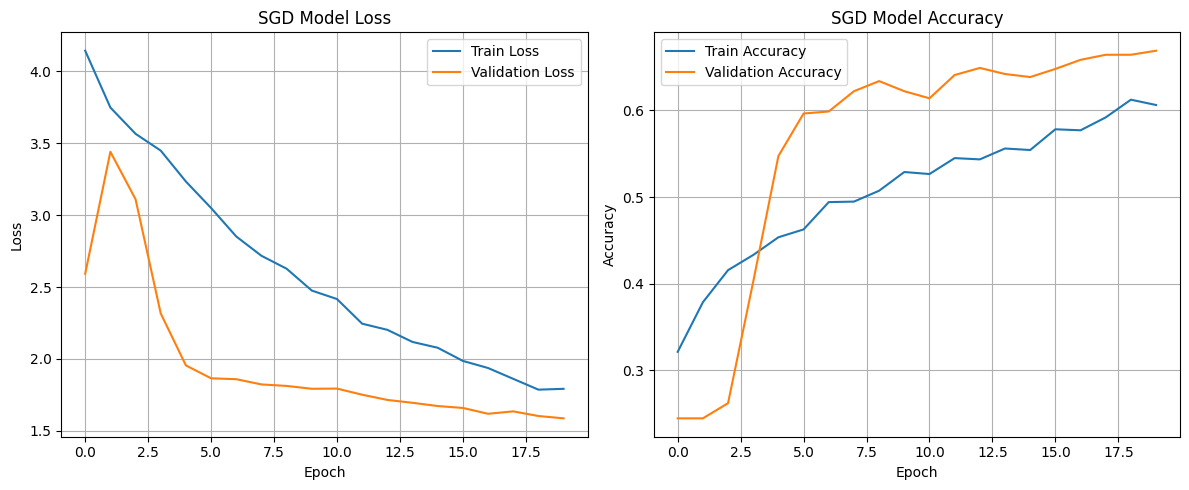

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# ----------- LOSS -------------
plt.subplot(1, 2, 1)
plt.plot(DeepModel_history_SGD.history['loss'], label='Train Loss')
plt.plot(DeepModel_history_SGD.history['val_loss'], label='Validation Loss')
plt.title("SGD Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ----------- ACCURACY -------------
plt.subplot(1, 2, 2)
plt.plot(DeepModel_history_SGD.history['accuracy'], label='Train Accuracy')
plt.plot(DeepModel_history_SGD.history['val_accuracy'], label='Validation Accuracy')
plt.title("SGD Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


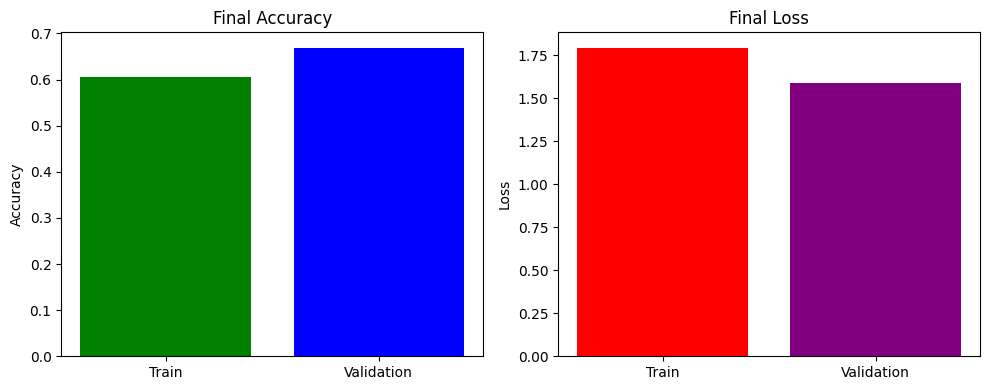

In [65]:
import matplotlib.pyplot as plt

# Get final values from history
final_train_acc = DeepModel_history_SGD.history['accuracy'][-1]
final_val_acc = DeepModel_history_SGD.history['val_accuracy'][-1]
final_train_loss = DeepModel_history_SGD.history['loss'][-1]
final_val_loss = DeepModel_history_SGD.history['val_loss'][-1]

# Bar chart
labels = ['Train', 'Validation']
acc_values = [final_train_acc, final_val_acc]
loss_values = [final_train_loss, final_val_loss]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy
axs[0].bar(labels, acc_values, color=['green', 'blue'])
axs[0].set_title('Final Accuracy')
axs[0].set_ylabel('Accuracy')

# Loss
axs[1].bar(labels, loss_values, color=['red', 'purple'])
axs[1].set_title('Final Loss')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()


In [ ]:
val_generator.reset()
Y_pred_deep = deep_model.predict(val_generator, steps=len(val_generator))
y_pred_deep = np.argmax(Y_pred_deep, axis=1)
y_true = val_generator.classes

print("Deeper Model Evaluation:\n")
print(classification_report(y_true, y_pred_deep, target_names=class_labels))

# Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False  # Freezing the convolutional layers to retain the learned features

x = base_model.output
x = Flatten()(x)  # Flatten the output of the convolutional layers
x = Dense(256, activation='relu')(x)  # Add a dense layer with 256 units
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(5, activation='softmax')(x)  # Output layer (adjust number of classes as needed)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Set up directories
train_dir = '/Users/sneharaut/Desktop/Flower_Classification/Train'  # Directory for training data
test_dir = '/Users/sneharaut/Desktop/Flower_Classification/Test'    # Directory for test data

# Image size expected by VGG16 (224x224)
img_size = (224, 224)
batch_size = 32

# Data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Resize images to 224x224 for VGG16
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='training',         # Use subset for training
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Resize images to 224x224 for VGG16
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='validation',       # Use subset for validation
    shuffle=True
)

Found 3424 images belonging to 5 classes.
Found 855 images belonging to 5 classes.


In [60]:
# Handling Test Data (Manually loading)
test_images = []
test_labels = []
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']  # Adjust this to match your dataset

# Manually load and preprocess test images
for img_name in os.listdir(test_dir):
    if img_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust based on your file types
        img_path = os.path.join(test_dir, img_name)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0  # Normalize image
        test_images.append(img_array)
        
        # Predict the label using the model
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        test_labels.append(predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [61]:
# Convert to numpy arrays and one-hot encode labels
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(class_names))

# Load VGG16 without top layers (pre-trained model)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model (convolutional layers)

# Add custom classification head
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)  # Add a fully connected layer
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting
output = layers.Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer for multi-class classification

In [62]:
# Create the model
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model (only the new layers will be trained)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [63]:
# Train the model (only the custom head layers will be trained)
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Fine-Tuning: Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True  # Unfreeze the last 4 layers

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model again with the base and custom layers trained
history_finetune = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on manually loaded test set
predictions = model.predict(test_images)

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.3624 - loss: 2.0237 - val_accuracy: 0.7275 - val_loss: 0.7272
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 365ms/step - accuracy: 0.6320 - loss: 1.2879 - val_accuracy: 0.7579 - val_loss: 0.6466
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - accuracy: 0.6736 - loss: 1.1231 - val_accuracy: 0.7930 - val_loss: 0.6017
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - accuracy: 0.7346 - loss: 0.9180 - val_accuracy: 0.7871 - val_loss: 0.6233
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - accuracy: 0.7561 - loss: 0.8160 - val_accuracy: 0.7965 - val_loss: 0.5881
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - accuracy: 0.7741 - loss: 0.7481 - val_accuracy: 0.7942 - val_loss: 0.6540
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 365ms/step - accuracy: 0.7945 - loss: 0.6592 - val_accuracy: 0.8023 - val_loss: 0.6180
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - accuracy: 0.8429 - loss: 0

In [64]:
# Calculate accuracy
predicted_class_indices = np.argmax(predictions, axis=1)
correct_predictions = np.sum(predicted_class_indices == np.argmax(test_labels, axis=1))
total_predictions = len(test_labels)
accuracy = correct_predictions / total_predictions
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 40.00%


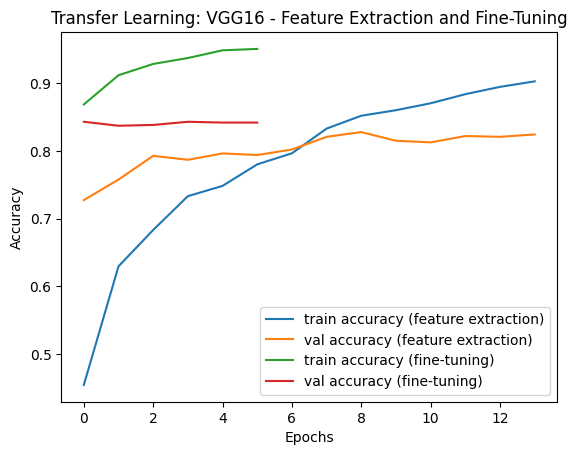

In [65]:
# Plot the accuracy for training and validation
plt.plot(history.history['accuracy'], label='train accuracy (feature extraction)')
plt.plot(history.history['val_accuracy'], label='val accuracy (feature extraction)')
plt.plot(history_finetune.history['accuracy'], label='train accuracy (fine-tuning)')
plt.plot(history_finetune.history['val_accuracy'], label='val accuracy (fine-tuning)')
plt.title("Transfer Learning: VGG16 - Feature Extraction and Fine-Tuning")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Test Accuracy: 40.00%

Classification Report:
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00         0
   dandelion       1.00      0.50      0.67         2
        rose       0.00      0.00      0.00         1
   sunflower       1.00      0.50      0.67         2
       tulip       0.00      0.00      0.00         0

    accuracy                           0.40         5
   macro avg       0.40      0.20      0.27         5
weighted avg       0.80      0.40      0.53         5



/Users/sneharaut/tensorflow_eni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sneharaut/tensorflow_eni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sneharaut/tensorflow_eni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


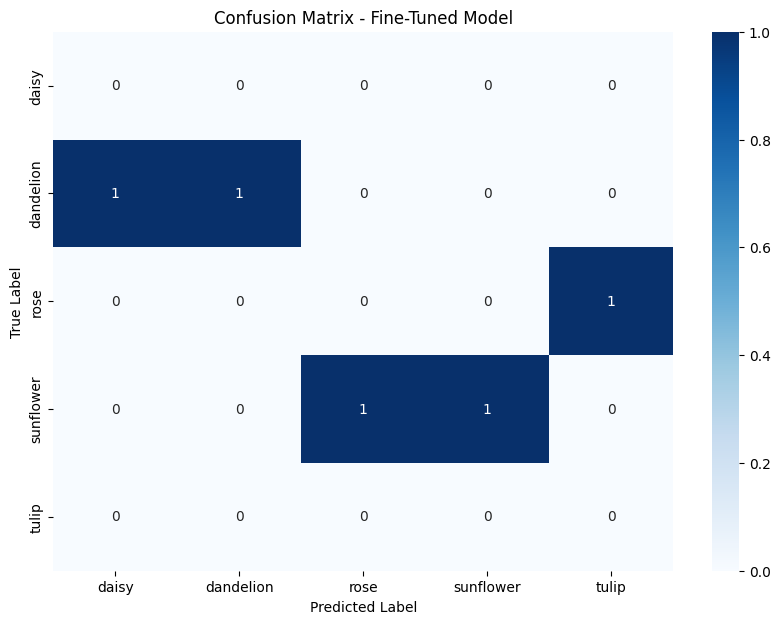

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict labels for test data
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Accuracy (already printed earlier)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix - Fine-Tuned Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [68]:
img_path = '/Users/sneharaut/Desktop/Flower_Classification/Train/rose/102501987_3cdb8e5394_n.jpg'  # Replace with actual path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0 

# Adding batch dimension
img_array = np.expand_dims(img_array, axis=0)  

# Make prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]

# Output result
print(f"Predicted class: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Predicted class: rose
